# Exploring the single member (mem001) control and historical run

In [1]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# ocean_scalar

In [2]:
hist_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101/ZARR/ocean_scalar_month.zarr.zip'
hist_nvol_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101-no_volcanos/mem001/'
ctrl_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101/ZARR/ocean_scalar_month.zarr.zip'
ctrl_nvol_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101-no_volcanos//ZARR/ocean_scalar_month.zarr.zip'

forcing_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101-no_volcanos/mem001/'

In [3]:
hist_ocean_scalar = xr.open_zarr(hist_path, consolidated=True).squeeze()

hist_nvol_files = sorted(glob.glob(f'{hist_nvol_path}ocean_scalar_*.nc'))[:-1] # Last year still writing
hist_nvol_ocean_scalar = xr.open_mfdataset(hist_nvol_files)

ctrl_ocean_scalar = xr.open_zarr(ctrl_path, consolidated=True).squeeze()

ctrl_nvol_ocean_scalar = xr.open_zarr(ctrl_nvol_path, consolidated=True).squeeze()

In [4]:
variable = 'temp_total'
variable_long_name = ctrl_nvol_ocean_scalar[variable].attrs['long_name']

clim_period = slice('1980','1999')
clim =  ctrl_nvol_ocean_scalar[variable].sel(time=clim_period).groupby('time.month').mean('time')

ctrl_ocean_scalar = ctrl_ocean_scalar[variable].groupby('time.month') - clim
ctrl_nvol_ocean_scalar = ctrl_nvol_ocean_scalar[variable].groupby('time.month') - clim
hist_ocean_scalar = hist_ocean_scalar[variable].groupby('time.month') - clim
hist_nvol_ocean_scalar = hist_nvol_ocean_scalar[variable].groupby('time.month') - clim

/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1

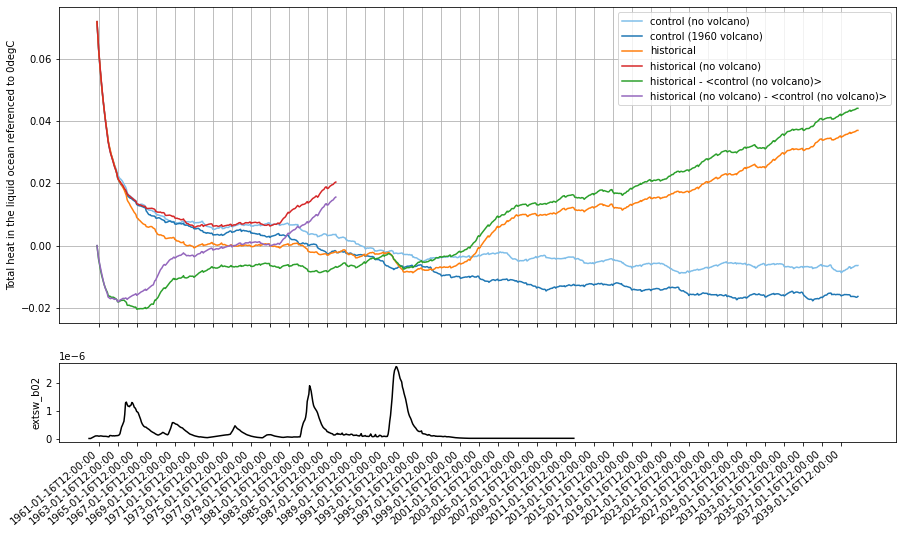

In [5]:
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(15,8))

def lighten(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

ax0.plot([np.datetime64(t.strftime()) for t in ctrl_nvol_ocean_scalar.time.values], 
         ctrl_nvol_ocean_scalar, 
         label='control (no volcano)', color=lighten('C0'), linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in ctrl_ocean_scalar.time.values], 
         ctrl_ocean_scalar, 
         label='control (1960 volcano)', color='C0', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in hist_ocean_scalar.time.values], 
         hist_ocean_scalar, 
         label='historical', color='C1', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in hist_nvol_ocean_scalar.time.values], 
         hist_nvol_ocean_scalar, 
         label='historical (no volcano)', color='C3', linestyle='-')

ctrl_nvol_ocean_scalar_smooth = ctrl_nvol_ocean_scalar.rolling(time=72, min_periods=1).mean('time')
ax0.plot([np.datetime64(t.strftime()) for t in (hist_ocean_scalar-ctrl_nvol_ocean_scalar_smooth).time.values], 
         hist_ocean_scalar-ctrl_nvol_ocean_scalar_smooth, 
         label='historical - <control (no volcano)>', color='C2', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in (hist_nvol_ocean_scalar-ctrl_nvol_ocean_scalar_smooth).time.values], 
         hist_nvol_ocean_scalar-ctrl_nvol_ocean_scalar_smooth, 
         label='historical (no volcano) - <control (no volcano)>', color='C4', linestyle='-')

ax0.legend()
ax0.set_ylabel(variable_long_name);
ax0.grid()
xticks = [np.datetime64(t.strftime()) for t in ctrl_nvol_ocean_scalar.time.values[2::24]]
ax0.set_xticks(xticks)
ax0.set_xticklabels([])
xlims = ax0.get_xlim()

f = xr.open_dataset(f'{forcing_path}INPUT/extsw_data.nc')

period = slice(str(ctrl_nvol_ocean_scalar.time[0].dt.year.values), 
               str(ctrl_nvol_ocean_scalar.time[-1].dt.year.values))
lev = 60

lat_mean = f['extsw_b02'].sel(time=period).mean('lat')
ax1.plot([np.datetime64(t.strftime()) for t in lat_mean.time.values],
        lat_mean.sel(pfull=lev, method='nearest'), color='k')
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation=40, ha='right');
ax1.set_ylabel('extsw_b02');
ax1.set_xlim(xlims);

# CO2 forcing

In [79]:
d = xr.open_zarr(
    '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101/ZARR/ocean_bgc_month.zarr.zip',
    consolidated=True)

In [80]:
def read_gblannualdata(file_name):
    with open(file_name, 'r') as data:
        next(data)
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))

    return xr.DataArray(y, dims=('year'), coords={'year': x})

f = read_gblannualdata(f'{forcing_path}INPUT/co2_gblannualdata')

In [81]:
def decimal_year_to_datetime(year):
    from datetime import datetime, timedelta
    year_int = int(year)
    rem = year - year_int
    base = datetime(year_int, 1, 1)
    return np.datetime64(
        base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem))


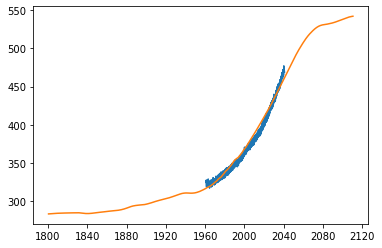

In [82]:
paco2 = d['paco2'].mean(['yt_ocean','xt_ocean']).squeeze()
plt.plot([np.datetime64(t.strftime()) for t in paco2.time.values], 
         paco2)
plt.plot([decimal_year_to_datetime(y) for y in f.year.values],
         f)

#### But remember that bgc co2 forcing is done differently, so this doesn't necessarily tell you how the other realms are going...

# aerosol forcing

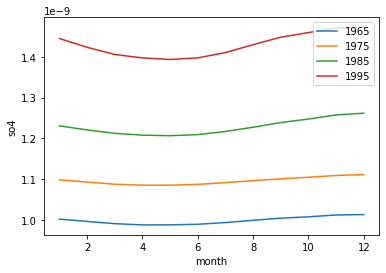

In [18]:
f = xr.open_dataset(f'{forcing_path}INPUT/aerosol.climatology.nc')
variable = 'so4'

periods = range(1965,2005,10)
for p in periods:
    var = f[variable].isel(sigma_full=0).sel(time=str(p)).mean(['lat','lon']) # Global average
    plt.plot(range(1,13), var)
plt.ylabel(variable)
plt.xlabel('month')
plt.legend(periods);

# atmos_month

In [18]:
hist_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101/ZARR/atmos_hybrid_month.zarr.zip'
hist_nvol_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/'
ctrl_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101/ZARR/atmos_hybrid_month.zarr.zip'
ctrl_nvol_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101-no_volcanos//ZARR/atmos_hybrid_month.zarr.zip'

forcing_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101-no_volcanos/mem001/'

In [20]:
hist_atmos_month = xr.open_zarr(hist_path, consolidated=True).squeeze()

hist_nvol_files = sorted(glob.glob(f'{hist_nvol_path}atmos_month_*.nc'))
hist_nvol_atmos_month = xr.open_mfdataset(hist_nvol_files)

ctrl_atmos_month = xr.open_zarr(ctrl_path, consolidated=True).squeeze()

ctrl_nvol_atmos_month = xr.open_zarr(ctrl_nvol_path, consolidated=True).squeeze()

area = ctrl_atmos_month['area']

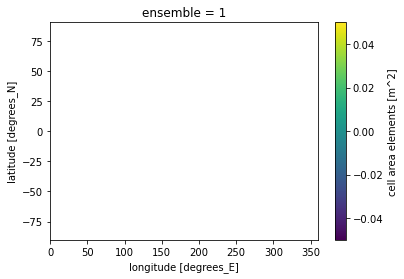

In [32]:
area.plot()

In [21]:
variable = 't_surf'
variable_long_name = ctrl_nvol_atmos_month[variable].attrs['long_name']

ctrl_atmos_month_gbl = ctrl_atmos_month[variable].weighted(area).mean(['lat','lon'])
ctrl_atmos_month_nvol_gbl = ctrl_nvol_atmos_month[variable].weighted(area).mean(['lat','lon'])
hist_atmos_month_gbl = hist_atmos_month[variable].weighted(area).mean(['lat','lon'])
hist_atmos_month_nvol_gbl = hist_nvol_atmos_month[variable].weighted(area).mean(['lat','lon'])

clim_period = slice('1980','1999')
clim =  ctrl_atmos_month_nvol_gbl.sel(time=clim_period).groupby('time.month').mean('time')

ctrl_atmos_month_gbl_anom = ctrl_atmos_month_gbl.groupby('time.month') - clim
ctrl_atmos_month_nvol_gbl_anom = ctrl_atmos_month_nvol_gbl.groupby('time.month') - clim
hist_atmos_month_gbl_anom = hist_atmos_month_gbl.groupby('time.month') - clim
hist_atmos_month_nvol_gbl_anom = hist_atmos_month_nvol_gbl.groupby('time.month') - clim

/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1

In [22]:
hist_gbl_vol_forcing = hist_atmos_month['vis_exopd_vl_c'].weighted(area).mean(['lat','lon'])
ctrl_gbl_vol_forcing = ctrl_atmos_month['vis_exopd_vl_c'].weighted(area).mean(['lat','lon'])

hist_gbl_qo3_forcing = hist_atmos_month['qo3_col'].weighted(area).mean(['lat','lon'])
hist_nvol_gbl_qo3_forcing = hist_nvol_atmos_month['qo3_col'].weighted(area).mean(['lat','lon'])
ctrl_gbl_qo3_forcing = ctrl_atmos_month['qo3_col'].weighted(area).mean(['lat','lon'])
ctrl_nvol_gbl_qo3_forcing = ctrl_nvol_atmos_month['qo3_col'].weighted(area).mean(['lat','lon'])

# ocean_month

In [24]:
hist_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101/ZARR/ocean_month.zarr.zip'
hist_nvol_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/'
ctrl_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101/ZARR/ocean_month.zarr.zip'
ctrl_nvol_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101-no_volcanos/ZARR/ocean_month.zarr.zip'

In [25]:
hist_ocean_month = xr.open_zarr(hist_path, consolidated=True)

hist_nvol_files = sorted(glob.glob(f'{hist_nvol_path}ocean_month_*.nc'))
hist_nvol_ocean_month = xr.open_mfdataset(hist_nvol_files)

ctrl_ocean_month = xr.open_zarr(ctrl_path, consolidated=True)

ctrl_nvol_ocean_month = xr.open_zarr(ctrl_nvol_path, consolidated=True)

In [26]:
def nino(sst_anom, index, wrap_lons=True, lat_name='yt_ocean', lon_name='xt_ocean'):
    """ Return nino3 index """
    def latlon_average(ds, box, wrap_lons=True, lat_name='yt_ocean', lon_name='xt_ocean'):
        def _get_latlon_region(ds, box, wrap_lons=True):
            ds = ds.assign_coords({lon_name: (ds[lon_name] + 360)  % 360})
            lon_inds = np.where(
                np.logical_and(ds[lon_name].values>=box[2], 
                               ds[lon_name].values<=box[3]))[0]
            lat_inds = np.where(
                np.logical_and(ds[lat_name].values>=box[0], 
                               ds[lat_name].values<=box[1]))[0]
            return ds.isel({lon_name: lon_inds, lat_name: lat_inds})

        return _get_latlon_region(ds, box, wrap_lons).mean(dim=[lat_name, lon_name])

    if index == '3':
        box = [-5.0, 5.0, 210.0, 270.0]
    elif index == '3.4':
        box = [-5.0, 5.0, 190.0, 240.0]
    elif index == '4':
        box = [-5.0, 5.0, 160.0, 210.0]
    else: raise InputError('Unrecognised input for index')
        
    return latlon_average(sst_anom, box, wrap_lons, lat_name, lon_name)

In [27]:
clim_period = slice('1980','1999')
clim =  ctrl_nvol_ocean_month['sst'].sel(time=clim_period).groupby('time.month').mean('time')

ctrl_sst = ctrl_ocean_month['sst'].groupby('time.month') - clim
ctrl_nvol_sst = ctrl_nvol_ocean_month['sst'].groupby('time.month') - clim
hist_sst = hist_ocean_month['sst'].groupby('time.month') - clim
hist_nvol_sst = hist_nvol_ocean_month['sst'].groupby('time.month') - clim

ctrl_nino3 = nino(ctrl_sst, index='3')
ctrl_nvol_nino3 = nino(ctrl_nvol_sst, index='3')
hist_nino3 = nino(hist_sst, index='3')
hist_nvol_nino3 = nino(hist_nvol_sst, index='3')

/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1

In [30]:
ctrl_atmos_month_nvol_gbl_anom.plot()

ValueError: `weights` cannot contain missing values. Missing values can be replaced by `weights.fillna(0)`.

ValueError: `weights` cannot contain missing values. Missing values can be replaced by `weights.fillna(0)`.

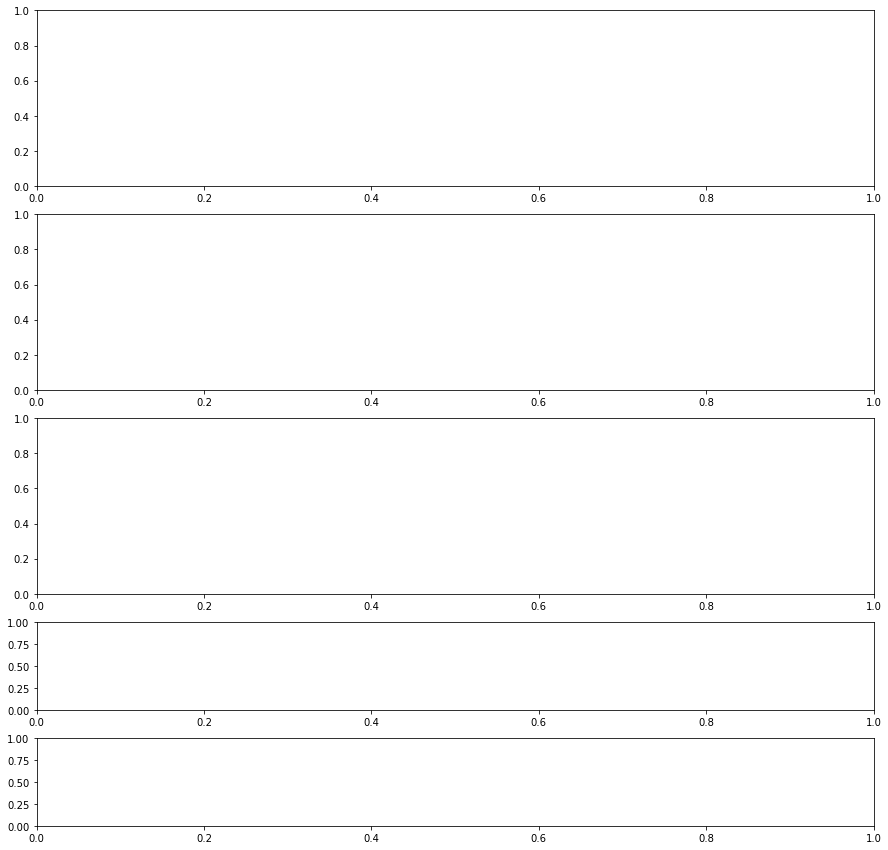

In [28]:
from matplotlib.ticker import FormatStrFormatter

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, 
                                              gridspec_kw={'height_ratios': [2, 2, 2, 1, 1]}, 
                                              figsize=(15,15))

ax0.plot([np.datetime64(t.strftime()) for t in ctrl_atmos_month_nvol_gbl_anom.time.values], 
         ctrl_atmos_month_nvol_gbl_anom, label='control (no volcano)', color=lighten('C0'), linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in ctrl_atmos_month_gbl_anom.time.values], 
         ctrl_atmos_month_gbl_anom, label='control (1960 volcano)', color='C0', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in hist_atmos_month_gbl_anom.time.values], 
         hist_atmos_month_gbl_anom, label='historical', color='C1')
ax0.plot([np.datetime64(t.strftime()) for t in hist_atmos_month_nvol_gbl_anom.time.values], 
         hist_atmos_month_nvol_gbl_anom, label='historical (no volcano)', color='C3')

ax0.legend()
ax0.set_ylabel(f'Global mean\n{variable_long_name}'); 
ax0.grid()
xticks = [np.datetime64(t.strftime()) for t in ctrl_atmos_month_nvol_gbl_anom.time.values[2::24]]
ax0.set_xticks(xticks)
ax0.set_xticklabels([])
xlims = ax0.get_xlim()

ctrl_atmos_month_nvol_gbl_anom_smooth = ctrl_atmos_month_nvol_gbl_anom.rolling(time=72, min_periods=1).mean('time')
ctrl_atmos_month_gbl_anom_smooth = ctrl_atmos_month_gbl_anom.rolling(time=72, min_periods=1).mean('time')
ax1.plot([np.datetime64(t.strftime()) for t in (hist_atmos_month_gbl_anom-ctrl_atmos_month_nvol_gbl_anom_smooth).time.values], 
         hist_atmos_month_gbl_anom-ctrl_atmos_month_nvol_gbl_anom_smooth, 
         label='historical - <control (no volcano)>', color='C2')
ax1.plot([np.datetime64(t.strftime()) for t in (hist_atmos_month_nvol_gbl_anom-ctrl_atmos_month_nvol_gbl_anom_smooth).time.values], 
         hist_atmos_month_nvol_gbl_anom-ctrl_atmos_month_nvol_gbl_anom_smooth, 
         label='historical (no volcano) - <control (no volcano)>', color='C4')
ax1.legend()
ax1.set_ylabel(f'"Drift-adjusted"\nglobal mean\n{variable_long_name}');
ax1.grid()
ax1.set_xticks(xticks)
ax1.set_xticklabels([])
ax1.set_xlim(xlims);

ax2.plot([np.datetime64(t.strftime()) for t in ctrl_nvol_nino3.time.values], 
         ctrl_nvol_nino3, label='control (no volcano)', color=lighten('C0'), linestyle='-')
ax2.plot([np.datetime64(t.strftime()) for t in ctrl_nino3.time.values], 
         ctrl_nino3, label='control (1960 volcano)', color='C0', linestyle='-')
ax2.plot([np.datetime64(t.strftime()) for t in hist_nino3.time.values], 
         hist_nino3, label='historical', color='C1')
ax2.plot([np.datetime64(t.strftime()) for t in hist_nvol_nino3.time.values], 
         hist_nvol_nino3, label='historical (no volcano)', color='C3')
# ax2.plot([np.datetime64(t.strftime()) for t in hist_nino34.time.values], 
#          hist_nino34, label='historical Nino 3.4', color='C4')
# ax2.plot([np.datetime64(t.strftime()) for t in hist_nino4.time.values], 
#          hist_nino4, label='historical Nino 4', color='C5')

# ax2.legend()
ax2.set_ylabel('NINO 3');
ax2.grid()
ax2.set_xticks(xticks)
ax2.set_xticklabels([])
ax2.set_xlim(xlims);

# ====================================================
# Forcing
ax3.plot([np.datetime64(t.strftime()) for t in ctrl_gbl_vol_forcing.time.values],
         ctrl_gbl_vol_forcing, 
         color='C0', label='control (1960 volcano)')
ax3.plot([np.datetime64(t.strftime()) for t in hist_gbl_vol_forcing.time.values],
         hist_gbl_vol_forcing, 
         color='C1',label='historical')
# ax3.legend()
ax3.grid()
ax3.set_xticks(xticks)
ax3.set_xticklabels([]);
ax3.set_ylabel('vis_exopd_vl_c');
ax3.set_xlim(xlims);

# ctrl_nvol_gbl_qo3_forcing.plot(ax=ax1, color=lighten('C0'))
ax4.plot([np.datetime64(t.strftime()) for t in ctrl_nvol_gbl_qo3_forcing.time.values],
         ctrl_nvol_gbl_qo3_forcing, color=lighten('C0'), label='control (no volcano)')
ax4.plot([np.datetime64(t.strftime()) for t in ctrl_gbl_qo3_forcing.time.values],
         ctrl_gbl_qo3_forcing, color='C0', label='control (1960 volcano)')
ax4.plot([np.datetime64(t.strftime()) for t in hist_gbl_qo3_forcing.time.values],
         hist_gbl_qo3_forcing, color='C1',label='historical')

ylims = ax4.get_ylim()
ax4.plot([np.datetime64('2005-01-01'), np.datetime64('2005-01-01')], 
         ylims, 'k:')
ax4.grid()
ax4.set_ylim(ylims)
ax4.set_xticks(xticks)
ax4.set_xticklabels(xticks, rotation=40, ha='right');
ax4.set_ylabel('qo3_col');
ax4.set_xlim(xlims);

# atmos_daily

In [80]:
hist_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist/'
ctrl_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/ctrl/'
ctrl_nvol_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/ctrl-no_volcanos/'

In [81]:
drop = ['bk', 'pk', 'average_T1', 'average_T2', 'average_DT', 'time_bounds']

hist_files = sorted(glob.glob(f'{hist_path}atmos_daily_*.nc'))
hist_atmos_daily = xr.open_mfdataset(hist_files).drop(drop)

ctrl_files = sorted(glob.glob(f'{ctrl_path}atmos_daily_*.nc'))
ctrl_atmos_daily = xr.open_mfdataset(ctrl_files).drop(drop)

ctrl_nvol_files = sorted(glob.glob(f'{ctrl_nvol_path}atmos_daily_*.nc'))
ctrl_nvol_atmos_daily = xr.open_mfdataset(ctrl_nvol_files).drop(drop)

/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  ret

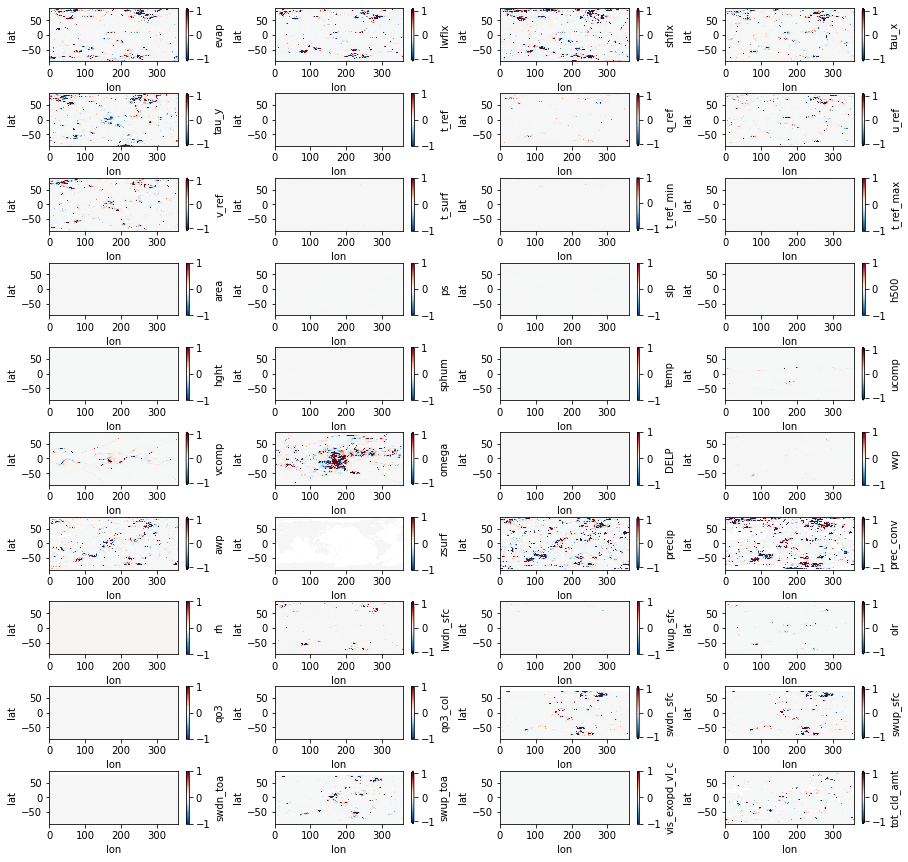

In [104]:
ncols = 4
nrows = 10

fig, axs = plt.subplots(nrows, ncols, figsize=(15,15))

a = ctrl_atmos_daily.isel(pfull=0, phalf=0, time=0)
b = hist_atmos_daily.isel(pfull=0, phalf=0, time=0)

variables = ctrl_atmos_daily.data_vars
for v, ax in zip(variables, axs.flatten()):
    (100 * (b[v] - a[v]) / a[v]).plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')
    ax.set_title('')
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    
plt.subplots_adjust(wspace=0.4, hspace=0.6)